             name                                           geometry  value
0       Saragozza  POLYGON ((11.31905 44.49696, 11.31914 44.49695...   3561
1           Murri  POLYGON ((11.36294 44.48912, 11.36303 44.48911...   3681
2      SantaViola  POLYGON ((11.31083 44.51134, 11.31082 44.51116...   3182
3       SanVitale  POLYGON ((11.42101 44.50836, 11.42187 44.50828...   3418
4           Saffi  POLYGON ((11.31847 44.51107, 11.3187 44.51101,...   3514
5           Barca  POLYGON ((11.30337 44.50128, 11.30366 44.50116...   2878
6         Marconi  POLYGON ((11.34378 44.49907, 11.3436 44.49847,...   4225
7       Bolognina  POLYGON ((11.35382 44.5044, 11.35367 44.50408,...   2947
8      Corticella  POLYGON ((11.37063 44.55166, 11.37067 44.55165...   2820
9        Malpighi  POLYGON ((11.32772 44.49906, 11.32935 44.49849...   4225
10        Mazzini  POLYGON ((11.391 44.4891, 11.39114 44.48905, 1...   3040
11      SRuffillo  POLYGON ((11.35938 44.4746, 11.35941 44.47456,...   3249
12  BorgoPan

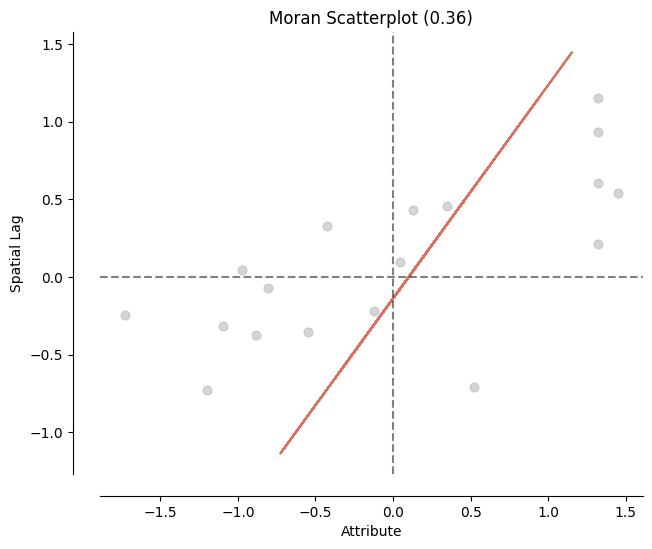

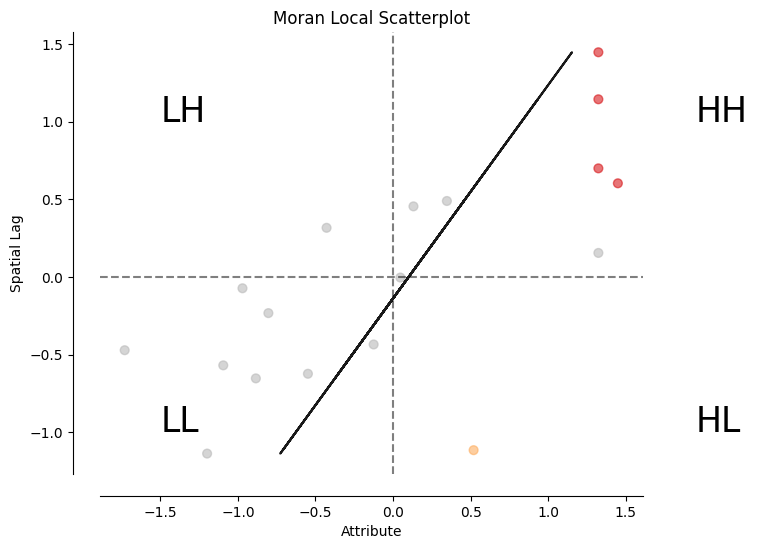

In [6]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pysal.lib import weights
from splot.libpysal import plot_spatial_weights
from esda.moran import Moran, Moran_Local
from pysal.explore import esda
from splot.esda import moran_scatterplot, plot_local_autocorrelation, lisa_cluster
import matplotlib.pyplot as plt
import folium
import matplotlib.colors as colors
import warnings
warnings.filterwarnings("ignore")
import json
from shapely import wkb
import sys


file_path = 'C:/Users/Utente PC/Desktop/SistemiContextAware/morandata.json'

with open(file_path, 'r', encoding='utf-8') as file:
    dati = json.load(file)

rows = dati['result']['rows']

names = [
    "Saragozza", "Murri", "SantaViola", "SanVitale", "Saffi", "Barca", 
    "Marconi", "Bolognina", "Corticella", "Malpighi", "Mazzini", 
    "SRuffillo", "BorgoPanigale", "Colli", "Galvani", "Irnerio", 
    "Lame", "SanDonato"
]

values = [
    3561, 3681, 3182, 3418, 3514, 2878, 4225, 2947, 2820, 4225, 
    3040, 3249, 2995, 4295, 4225, 4225, 3777, 2524
]

geometries = []

for row in rows:
    geometries.append(row['wkb_geometry'])


df = pd.DataFrame({
    'name': names,
    'geometry': geometries,
    'value': values
})


# Funzione per convertire WKB in geometrie shapely
def wkb_to_geometry(wkb_geom):
    return wkb.loads(wkb_geom, hex=True)

df['geometry'] = df['geometry'].apply(wkb_to_geometry)

# Creare un GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Creare la matrice dei pesi spaziali (contiguità dei poligoni)
w = weights.Queen.from_dataframe(gdf)

print(gdf)

# Transforming weights into binary (if it's 1 = is neighbor, 0 = not neighbor)
w.transform = "B"

# Showing neighbors indexes
print(w.neighbors)

# Showing weights
print(w.weights)

# Calculating Spatial Lag
gdf['w_values'] = weights.lag_spatial(w, gdf['value'])

print(gdf[['name', 'value', 'w_values']].head())

y_value = gdf['value']

moran = Moran(y_value, w)

# The Moran’s I statistic ranges from -1 to 1 and it indicates if the variable is spatially clustered, dispersed or random.
print("Moran's I:", moran.I)

# Indicates a positive spatial correlation. Similar house prices tend to be close to each other.

# However, only with this measure we can’t tell if we can be certain that the variable is spatially clustered.
# To be certain of that, we can calculate the p-value to test if the result of Moran’s statistic is significant or not.
# The null hypothesis of Moran’s I is that the values are randomly distributed in space.
print("p-value simulated:", moran.p_sim)

# Reject the null hypothesis of no spatial correlation. There is a significant spatial correlation in house prices.


moran_scatterplot(moran) # More or less as x increases, y increases. So, when the price is high, its neighbors also tend to have a high price. X-axis = value, Y-axis = Spatial Lag (w_value)

plt.show()

# Local Moran's I
value_local_moran = Moran_Local(y_value, w)

# Plotting Local Moran's I scatterplot of value
fig, ax = moran_scatterplot(value_local_moran, p=0.05)

plt.text(1.95, 1, 'HH', fontsize=25)
plt.text(1.95, -1.0, 'HL', fontsize=25)
plt.text(-1.5, 1, 'LH', fontsize=25)
plt.text(-1.5, -1, 'LL', fontsize=25)
plt.show()

# creating column with local_moran classification
gdf['value_local_moran'] = value_local_moran.q

# Dict to map local moran's classification codes
local_moran_classification = {1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL'}

# Mapping local moran's classification codes
gdf['value_local_moran'] = gdf['value_local_moran'].map(local_moran_classification)

# p-value for each observation/neighbor pair
gdf['value_local_moran_p_sim'] = value_local_moran.p_sim

# If p-value > 0.05 it is not statistical significant
gdf['value_local_moran'] = np.where(gdf['value_local_moran_p_sim'] > 0.05, 'ns', gdf['value_local_moran'])

gdf.head()

# Plotting Local Moran's I classification map of value column
gdf.explore(
    tiles='cartodbpositron',
    column='value_local_moran',
    height='70%',
    width='70%',
    cmap=[
    '#D7191C', # Red
    '#FDAE61', # Orange
    '#ABD9E9', # Light Blue
    '#2C7BB6', # Blue
    '#D3D3D3'  # Grey
    ],
    style_kwds={
        'stroke': True,
        'edgecolor': 'k',
        'linewidth': 0.03,
        'fillOpacity': 1
        
    },
    legend=True
)

gdf_json = gdf.__geo_interface__

# Salviamo il contenuto in un file JSON
output_file = 'outputMoran.json'
with open(output_file, 'w') as f:
    json.dump(gdf_json, f)

moran_values = {
    "Moran's I": moran.I,
    "p-value simulated": moran.p_sim
}

# Salviamo i valori di Moran's I e p-value simulato in un file JSON separato
output_moran_file = 'moranI.json'
with open(output_moran_file, 'w') as f:
    json.dump(moran_values, f)